# Understanding Decision Trees with Scikit-Learn

Decision Trees are a fundamental supervised machine learning algorithm used for both **classification** and **regression** tasks. They are intuitive, easy to interpret, and form the basis for more complex ensemble methods like Random Forests and Gradient Boosting.

The goal of a Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. It does this by recursively partitioning the data into smaller and smaller subsets based on the feature values.

### How Decision Trees Work

Imagine a flowchart where each internal node represents a "test" on a feature (e.g., "Is petal width <= 0.8 cm?"), each branch represents the outcome of the test (e.g., True/False), and each leaf node represents a class label (in classification) or a continuous value (in regression). 

The tree starts with a **root node** containing the entire dataset. At each node, the algorithm selects the **best feature** and the **best split point** for that feature to partition the data into subsets. The "best" split is typically the one that results in the most homogeneous subsets with respect to the target variable (i.e., subsets that contain predominantly instances of a single class).

This splitting process continues recursively for each subset until one of the stopping criteria is met:
*   All instances in a subset belong to the same class (the node is "pure").
*   A predefined maximum depth of the tree is reached (`max_depth`).
*   The number of instances in a node is less than a minimum threshold required for splitting (`min_samples_split`).
*   The number of instances in a potential leaf node is less than a minimum threshold (`min_samples_leaf`).

The final nodes that do not split further are called **leaf nodes** (or terminal nodes), and they contain the prediction for new instances that reach them.

### Splitting Criteria (for Classification)

How does the tree decide the "best" feature and split point? It uses criteria that measure the **impurity** or **homogeneity** of the nodes. The goal is to maximize the impurity reduction (or information gain) at each split.

1.  **Gini Impurity:** Measures the probability of incorrectly classifying a randomly chosen element in the subset if it were randomly labeled according to the class distribution in the subset. 
    *   Formula: \( Gini = 1 - \sum_{i=1}^{C} (p_i)^2 \), where \( C \) is the number of classes and \( p_i \) is the proportion of instances of class \( i \) in the node.
    *   A Gini impurity of 0 means the node is pure (all instances belong to one class).
    *   A Gini impurity of 0.5 (for binary classification) means the node has an equal distribution of classes.
    *   Scikit-learn default: `criterion='gini'`.

2.  **Entropy / Information Gain:** Entropy measures the amount of uncertainty or randomness in a node. Information Gain measures the reduction in entropy achieved by splitting the data on a particular feature.
    *   Formula (Entropy): \( Entropy = - \sum_{i=1}^{C} p_i \log_2(p_i) \)
    *   Formula (Information Gain): \( IG(Node, Feature) = Entropy(Node) - \sum_{subset \in Split} \frac{|subset|}{|Node|} Entropy(subset) \)
    *   The split that maximizes Information Gain (or minimizes the weighted average entropy of the child nodes) is chosen.
    *   Scikit-learn option: `criterion='entropy'`.

### Important Hyperparameters

Controlling the complexity of the tree is crucial to prevent overfitting.

*   `criterion`: The function to measure the quality of a split ('gini' or 'entropy').
*   `max_depth`: The maximum depth of the tree. Limiting depth helps prevent overfitting by making the model less complex.
*   `min_samples_split`: The minimum number of samples required to split an internal node. Increasing this value can prevent splits on small, potentially noisy groups of samples.
*   `min_samples_leaf`: The minimum number of samples required to be at a leaf node. Similar to `min_samples_split`, this ensures leaves are not too specific and helps prevent overfitting.
*   `max_features`: The number of features to consider when looking for the best split. Can introduce randomness similar to Random Forests if set to less than the total number of features.
*   `max_leaf_nodes`: Grow a tree with `max_leaf_nodes` in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
*   `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value. Helps in pruning.

### Pruning

Decision trees have a tendency to overfit the training data, creating overly complex trees that capture noise. **Pruning** is a technique used to reduce the size of the tree by removing sections (nodes and branches) that provide little predictive power. 

*   **Pre-pruning (Early Stopping):** Stops the tree from growing further when certain conditions are met (e.g., reaching `max_depth`, `min_samples_leaf`, `min_impurity_decrease`). This is controlled by the hyperparameters mentioned above.
*   **Post-pruning (Not directly implemented in scikit-learn's basic `DecisionTreeClassifier` but conceptually important):** Grows the full tree first and then removes branches. Cost Complexity Pruning (`ccp_alpha`) is a form of post-pruning available in scikit-learn.

### Pros and Cons of Decision Trees

**Pros:**
*   **Interpretable:** Easy to understand and visualize the decision rules.
*   **Handles Both Numerical and Categorical Data:** Can work with different types of features (though scikit-learn requires categorical features to be numerically encoded).
*   **Non-Linearity:** Can capture non-linear relationships between features and the target.
*   **Requires Little Data Preparation:** No need for feature scaling (normalization/standardization) as splits are based on single feature thresholds.
*   **Feature Importance:** Implicitly performs feature selection, as important features are likely to appear higher up in the tree.

**Cons:**
*   **Prone to Overfitting:** Can easily create overly complex trees that don't generalize well to unseen data. Requires careful tuning and pruning.
*   **Instability:** Small variations in the data can result in a completely different tree being generated.
*   **Bias towards Features with More Levels:** Can be biased towards features with many distinct values when calculating impurity.
*   **Optimal Tree is NP-Hard:** Finding the globally optimal decision tree is computationally expensive, so algorithms rely on greedy approaches (making the best local choice at each step), which may not yield the best overall tree.

### Implementation with Scikit-Learn

#### 1. Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.datasets import load_iris # Using the Iris dataset for simplicity

# Configure plots for better visualization
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('ggplot') # Fallback style
    print("Style 'seaborn-v0_8-whitegrid' not found, using 'ggplot' instead.")

#### 2. Load Data

We'll use the classic Iris dataset, which has 3 classes (species of Iris) and 4 features (sepal length/width, petal length/width).

Dataset shape: (150, 6)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Class names: ['setosa' 'versicolor' 'virginica']
First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   Target Species  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa  


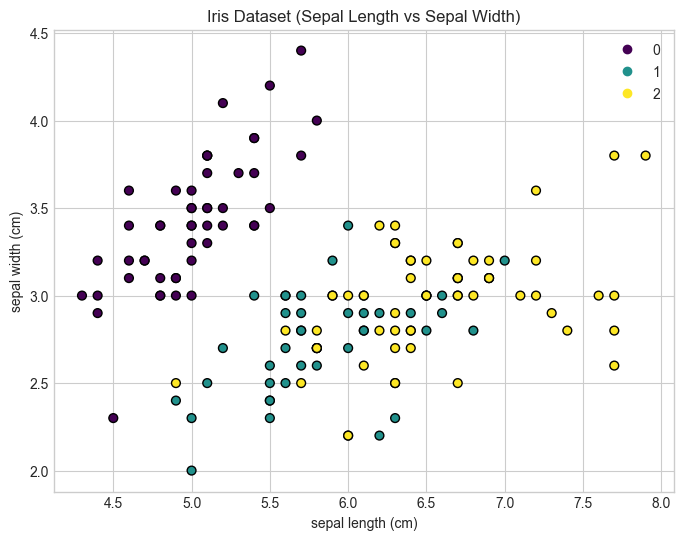

In [12]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# Convert to DataFrame (optional, for viewing)
df = pd.DataFrame(X, columns=feature_names)
df['Target'] = y
df['Species'] = df['Target'].map({0: class_names[0], 1: class_names[1], 2: class_names[2]})

print("Dataset shape:", df.shape)
print("Feature names:", feature_names)
print("Class names:", class_names)
print("First 5 rows:")
print(df.head())

# Visualize the data (using first two features for simplicity)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, edgecolor='k', s=40)
plt.title('Iris Dataset (Sepal Length vs Sepal Width)')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.grid(True)
handles, labels = scatter.legend_elements()
plt.legend(handles=handles, labels=labels)
plt.show()

#### 3. Train/Test Split

In [4]:
# Split the dataset into Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 105 samples
Test set size: 45 samples


#### 4. Feature Scaling (Not Required for Decision Trees)

Decision Trees work by making splits based on feature thresholds (e.g., `petal width <= 0.8`). The scale of the features does not affect these threshold-based decisions. Therefore, feature scaling (like `StandardScaler` or `MinMaxScaler`) is **not necessary** for Decision Tree algorithms.

In [5]:
# No feature scaling needed for Decision Trees
X_train_processed = X_train
X_test_processed = X_test
print("Feature scaling skipped as it's not required for Decision Trees.")

Feature scaling skipped as it's not required for Decision Trees.


#### 5. Training the Decision Tree Model

We'll use scikit-learn's `DecisionTreeClassifier`. We'll start with default parameters but set a `max_depth` to prevent the tree from becoming too complex initially and ensure reproducibility with `random_state`.

In [6]:
# Create and train the Decision Tree classifier
# Let's limit the depth initially to prevent overfitting and make visualization easier
dt_classifier = DecisionTreeClassifier(criterion='gini', # Default splitting criterion
                                     max_depth=3,      # Limit tree depth
                                     random_state=42   # For reproducibility
                                    )

# Train the model
dt_classifier.fit(X_train_processed, y_train)

print(f"Decision Tree Classifier trained with max_depth={dt_classifier.max_depth}.")

Decision Tree Classifier trained with max_depth=3.


#### 6. Making Predictions

In [7]:
# Predict the Test set results
y_pred = dt_classifier.predict(X_test_processed)

# Display predictions vs actual values (optional)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df['Actual Species'] = results_df['Actual'].map({0: class_names[0], 1: class_names[1], 2: class_names[2]})
results_df['Predicted Species'] = results_df['Predicted'].map({0: class_names[0], 1: class_names[1], 2: class_names[2]})

print("First 10 predictions:")
print(results_df[['Actual Species', 'Predicted Species']].head(10))

First 10 predictions:
  Actual Species Predicted Species
0      virginica         virginica
1     versicolor        versicolor
2      virginica         virginica
3     versicolor        versicolor
4      virginica         virginica
5      virginica         virginica
6     versicolor        versicolor
7     versicolor        versicolor
8         setosa            setosa
9      virginica         virginica


#### 7. Evaluating the Model

In [8]:
# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=class_names)

print("\n--- Model Evaluation ---")
print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report:")
print(report)


--- Model Evaluation ---
Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  0 15]]

Accuracy: 0.9778

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



#### 8. Visualizing the Decision Tree

One of the main advantages of Decision Trees is their interpretability. We can visualize the trained tree using `sklearn.tree.plot_tree`.

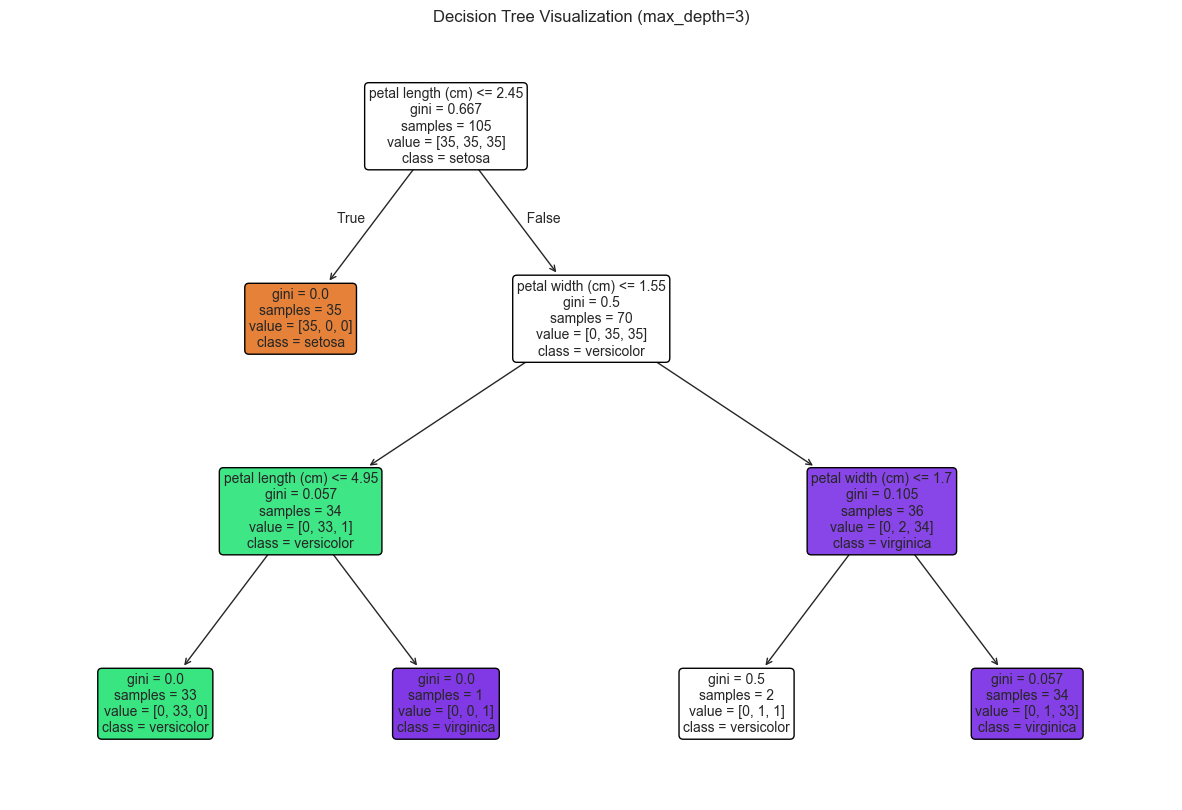

In [9]:
# Visualize the trained Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True,      # Color nodes by majority class
          rounded=True,     # Use rounded rectangles
          fontsize=10)
plt.title(f"Decision Tree Visualization (max_depth={dt_classifier.max_depth})")
plt.show()

**Interpreting the Visualization:**
*   Each node shows the splitting condition (e.g., `petal width (cm) <= 0.8`).
*   `gini`: The Gini impurity of the node.
*   `samples`: The number of training samples reaching the node.
*   `value`: The distribution of training samples among the classes at that node (e.g., `[35, 35, 35]` means 35 samples of each class).
*   `class`: The majority class predicted at that node.
*   Leaf nodes (nodes with no outgoing branches) represent the final predictions.

#### 9. Visualizing the Decision Boundary (using 2 features)

To visualize the decision boundary, we need to train a tree using only two features.

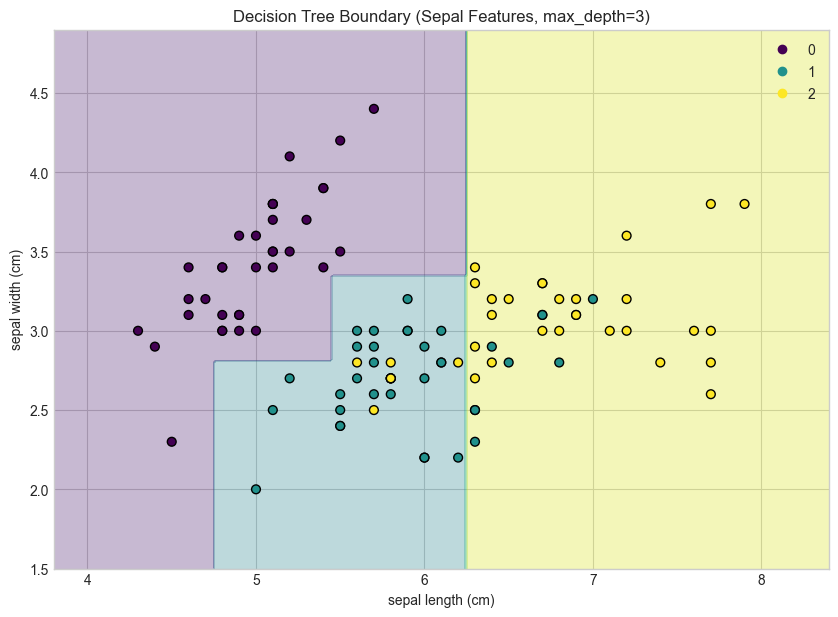

In [11]:
# Select only the first two features (Sepal Length and Sepal Width)
X_train_2f = X_train[:, :2]
X_test_2f = X_test[:, :2]

# Train a new Decision Tree on these 2 features
dt_classifier_2f = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
dt_classifier_2f.fit(X_train_2f, y_train)

# Function to plot decision boundaries
def plot_decision_boundary_2f(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                           np.arange(y_min, y_max, 0.02))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.viridis)
    
    # Plot the training points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, edgecolor='k', s=40)
    
    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.grid(True)
    handles, labels = scatter.legend_elements()
    plt.legend(handles=handles, labels=labels)
    plt.show()

# Plot decision boundary for the 2-feature model on the training data
plot_decision_boundary_2f(X_train_2f, y_train, dt_classifier_2f, 
                            'Decision Tree Boundary (Sepal Features, max_depth=3)')

The plot shows how the Decision Tree carves up the feature space using axis-aligned splits (horizontal and vertical lines) to separate the classes.

#### 10. Hyperparameter Tuning (Example with max_depth)

Let's find the optimal `max_depth` using GridSearchCV.


Starting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters found: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
Best cross-validation accuracy: 0.9524

--- Evaluation of Best Model from GridSearchCV (on Test Set) ---
Test Set Accuracy: 0.9778

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


Visualizing the best tree found (max_depth=3)...


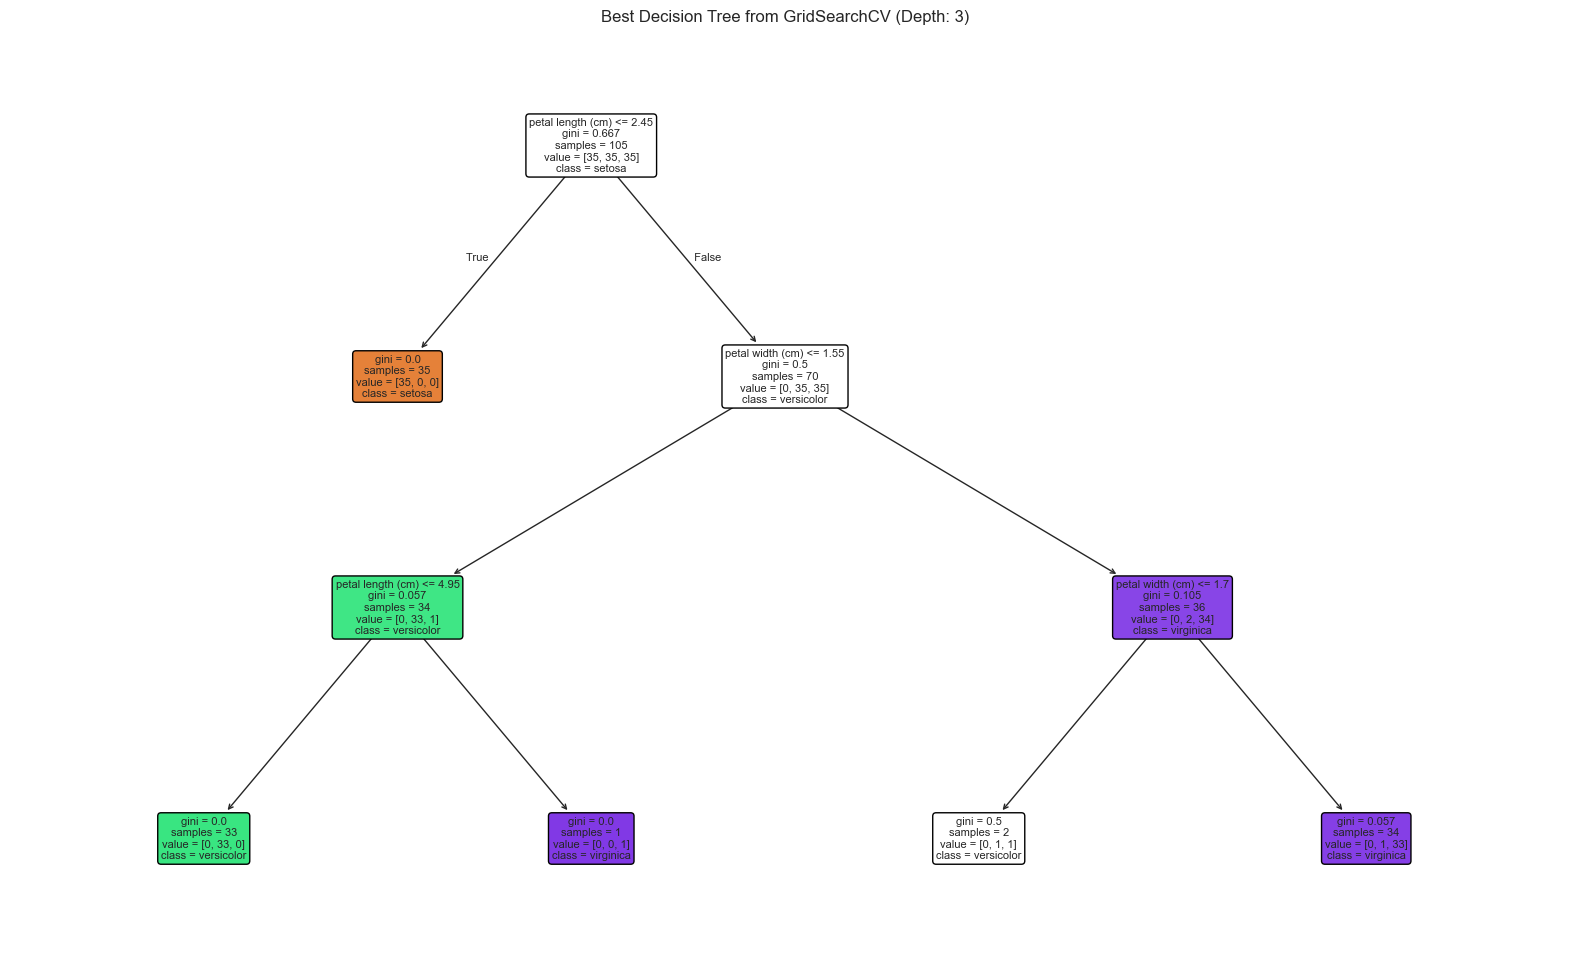

In [13]:
# Define the parameter grid for max_depth
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, None], # Test different depths (None means no limit)
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 3, 5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                           param_grid, 
                           refit=True, 
                           verbose=1, 
                           cv=5, # 5-fold cross-validation
                           scoring='accuracy')

# Fit grid search (using all features)
print("\nStarting GridSearchCV for Decision Tree...")
grid_search.fit(X_train_processed, y_train)

# Best parameters and score
print("\nBest parameters found:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best model found by grid search on the test set
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test_processed)
acc_best = accuracy_score(y_test, y_pred_best)

print("\n--- Evaluation of Best Model from GridSearchCV (on Test Set) ---")
print(f"Test Set Accuracy: {acc_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=class_names))

# Visualize the best tree (optional, might be large if max_depth is high)
print(f"\nVisualizing the best tree found (max_depth={best_dt.max_depth})...")
plt.figure(figsize=(20, 12))
plot_tree(best_dt, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          rounded=True, 
          fontsize=8)
plt.title(f"Best Decision Tree from GridSearchCV (Depth: {best_dt.max_depth})")
plt.show()

### Conclusion

This notebook introduced the Decision Tree algorithm for classification.

Key takeaways:
*   Decision Trees build a flowchart-like structure to make predictions based on **recursive partitioning** of data.
*   Splits are chosen based on criteria like **Gini impurity** or **entropy** to maximize homogeneity in child nodes.
*   They are highly **interpretable** and can be easily **visualized**.
*   They **do not require feature scaling**.
*   They are prone to **overfitting**, which can be mitigated using hyperparameters like `max_depth`, `min_samples_leaf`, and pruning techniques.
*   They form the basis for powerful **ensemble methods** like Random Forests.

Decision Trees are a versatile and intuitive starting point for many classification and regression problems.